<a href="https://colab.research.google.com/github/MikailINTech/PFE_2020/blob/master/PFE_VM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import tqdm
import statistics
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

print("pandas version %s" % pd.__version__)

pandas version 1.1.5


In [ ]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = '1GdD5momAHv8neSzojp_RfbajZYtV0EpK'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Data_CAC_traite2.csv')  

In [ ]:
data=pd.read_csv("Data_CAC_traite2.csv",
                 delimiter=';',
                 header=0,
                 parse_dates=['Date'],
                 decimal=',', #Bassem - Ici
                 quoting=csv.QUOTE_NONNUMERIC)
# Find the columns where each value is null
empty_cols = [col for col in data.columns if data[col].isnull().all()]
# Drop these columns from the dataframe
data.drop(empty_cols,
        axis=1,
        inplace=True)

data.info()
data.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7251 entries, 0 to 7250
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7251 non-null   datetime64[ns]
 1   Cac index  7251 non-null   float64       
 2   Volume     7251 non-null   float64       
 3   RSI        7251 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 226.7 KB


,Date,Cac index,Volume,RSI
0,1993-01-01,0.00,0.0,0.00
1,1993-01-04,-0.79,1690949.0,70.55
2,1993-01-05,0.42,3056650.0,71.69
3,1993-01-06,0.48,5327612.0,72.99
4,1993-01-07,-0.82,3953835.0,67.30
5,1993-01-08,0.44,5763855.0,68.71
6,1993-01-11,-2.05,4171935.0,56.45
7,1993-01-12,-0.98,3557165.0,51.79
8,1993-01-13,-0.79,3737305.0,48.36
9,1993-01-14,1.18,4589709.0,53.28


In [ ]:
data = data.set_index(data['Date'])
data=data[data.RSI!=0] #On retire les lignes dont les données manquent
data=data[data.Volume!=0]
#Bassem - Ok, mais Attention, il faut mesurer quel est l'effet du décalage engendré par les jours de fermeture des marchés, sinon se baser exclusivement sur les dates.

#Ajout d'une sinusoïde
length_days = (data.index - data.index[0]).days[-1]
x = (data.index - data.index[0]).days
data['sinusoide']=np.sin(256*np.pi*x/length_days)+np.cos(128*np.pi*x/length_days)

In [ ]:
def base100(dataframe, assetName):
  base = 100.0

  dataframe = dataframe.sort_index()
  dataframe['opening_price'] = base * (1 + dataframe[assetName].shift(1).fillna(0)/100).cumprod()
  dataframe['closing_price'] = base * (1 + dataframe[assetName]/100).cumprod()
  dataframe['days_from_start'] = (dataframe.index - dataframe.index[0]).days

  return dataframe

data = base100(data, 'Cac index')

data['Year'] = data.index.year
data['Month'] = data.index.month
data['Weekday'] = data.index.dayofweek


data.head(25)

,Date,Cac index,Volume,RSI,sinusoide,opening_price,closing_price,days_from_start,Year,Month,Weekday
Date,,,,,,,,,,,
1993-01-04,1993-01-04,-0.79,1690949.0,70.55,1.000000,100.000000,99.210000,0,1993,1,0
1993-01-05,1993-01-05,0.42,3056650.0,71.69,1.078399,99.210000,99.626682,1,1993,1,1
1993-01-06,1993-01-06,0.48,5327612.0,72.99,1.154732,99.626682,100.104890,2,1993,1,2
1993-01-07,1993-01-07,-0.82,3953835.0,67.30,1.228507,100.104890,99.284030,3,1993,1,3
1993-01-08,1993-01-08,0.44,5763855.0,68.71,1.299243,99.284030,99.720880,4,1993,1,4
1993-01-11,1993-01-11,-2.05,4171935.0,56.45,1.488596,99.720880,97.676602,7,1993,1,0
1993-01-12,1993-01-12,-0.98,3557165.0,51.79,1.542638,97.676602,96.719371,8,1993,1,1
1993-01-13,1993-01-13,-0.79,3737305.0,48.36,1.591467,96.719371,95.955288,9,1993,1,2
1993-01-14,1993-01-14,1.18,4589709.0,53.28,1.634714,95.955288,97.087560,10,1993,1,3


Text(0, 0.5, 'CAC40 Index (base 100)')

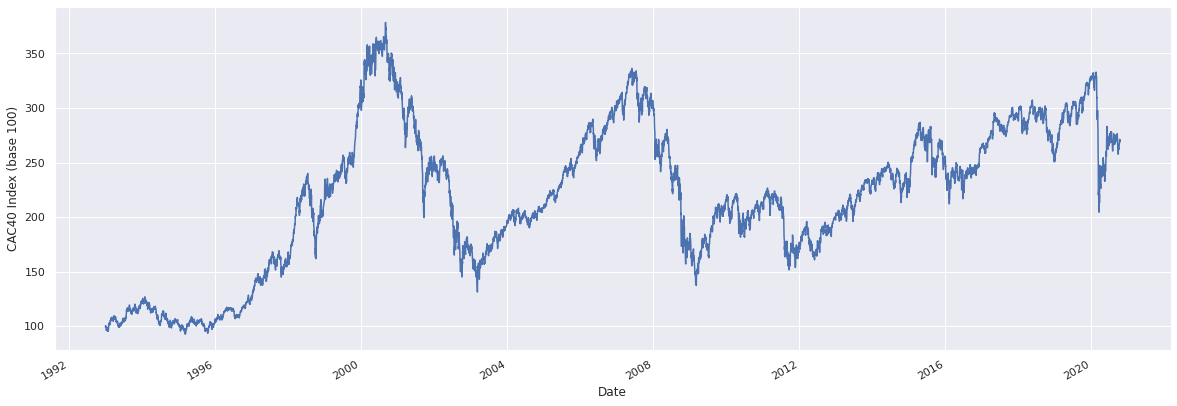

In [ ]:
sns.set(rc={'figure.figsize':(20, 7)})
ploted = data['opening_price'].plot()
ploted.set_ylabel('CAC40 Index (base 100)')

In [ ]:
#scaler = MinMaxScaler()
#data[['Volume']] = scaler.fit_transform(data[['Volume']])

training_set = data.iloc[:5000, :]
test_set = data.iloc[5000:, :]

In [ ]:
def coefDirecteur(dataframe, xlab, ylab):
  x = dataframe[xlab].values.reshape(-1, 1)
  y = dataframe[ylab].values
  
  model = linear_model.LinearRegression().fit(x, y)
  # Bassem - je n'ai pas cherché à jouer sur la méthode de calibration. Suivant la méthode utilisée on peut avoir des différences sur les coefs directeur, mais de mon avis, non significatif

  return model.coef_[0]

def classification(v,b):
  if v >= b*(1+0.00):
    return 1
  else:
    return 0

# Creating a data structure with 60 time-steps and 1 output
PAST_WINDOW = 122
FUTURE_WINDOW = 10
X_train = []
y_train = []

X_test = []
y_test = []

mean_diff=[]

XT_audit = []
yT_audit = []
subdata_audit = []
data_audit = []

from random import randrange
RAND = randrange(PAST_WINDOW, len(training_set) - FUTURE_WINDOW) #On choisi un nombre aléatoire entre PAST_WINDOW et la taille du train set - FUTURE_WINDOW (C'est la partie du tableau de données sur laquelle on peut classifier les semaines qui suivent)

for i in tqdm.tqdm(range(PAST_WINDOW, len(training_set) - FUTURE_WINDOW)):
    subdata = base100(training_set[(i-PAST_WINDOW):(i+FUTURE_WINDOW)], 'Cac index')
    
    a = subdata.opening_price[:-FUTURE_WINDOW]
    b = subdata.RSI[:-FUTURE_WINDOW]
    c = subdata['Cac index'].values[:-FUTURE_WINDOW]

    l = np.column_stack((a, b, c))
    
    #mp = subdata.opening_price[:-FUTURE_WINDOW].tail(FUTURE_WINDOW).mean() #Moyenne des opening prices sur les future_window derniers jours de l'année
    #mf = subdata.opening_price.tail(FUTURE_WINDOW).mean() #Moyenne des opening prices sur les future_window jours qui suivent l'année
    
    mp = subdata.opening_price[:-FUTURE_WINDOW].tail(1).mean() #Moyenne des opening prices sur les future_window derniers jours de l'année
    mf = subdata.opening_price.tail(1).mean() #Moyenne des opening prices sur les future_window jours qui suivent l'année
    

    X_train.append( l )
    y_train.append( classification(mf, mp) )
    mean_diff.append((mf-mp)/mp)


    # AUDIT DE CODE
    if i == RAND:
      print("\n\nAudited index: {}".format(RAND - PAST_WINDOW))
      print("Mean past: {} vs Mean future: {}".format(mp,mf))
      print("Begin index: {} vs End index: {}\n".format((i-PAST_WINDOW),(i+FUTURE_WINDOW)))
      
      subdataf = subdata.tail(FUTURE_WINDOW).copy() #future_window derniers jours de l'année
      subdatap = subdata[:-FUTURE_WINDOW].tail(FUTURE_WINDOW).copy() #future_window jours qui suivent l'année

      subdatap['mp'] =  mp
      subdataf['mf'] =  mf

      XT_audit.append(a)
      XT_audit.append(subdatap.mp)
      XT_audit.append(subdataf.mf)

      yT_audit.append(classification(mf, mp))
      subdata_audit.append(subdata)
      data_audit.append(subdata)

      BINDEX_AUDIT = (i-PAST_WINDOW)
      EINDEX_AUDIT = (i+FUTURE_WINDOW)

 79%|███████▊  | 3828/4868 [00:11<00:03, 330.77it/s]



Audited index: 3783
Mean past: 84.79398604520567 vs Mean future: 80.33248190849042
Begin index: 3783 vs End index: 3915



100%|██████████| 4868/4868 [00:14<00:00, 330.39it/s]


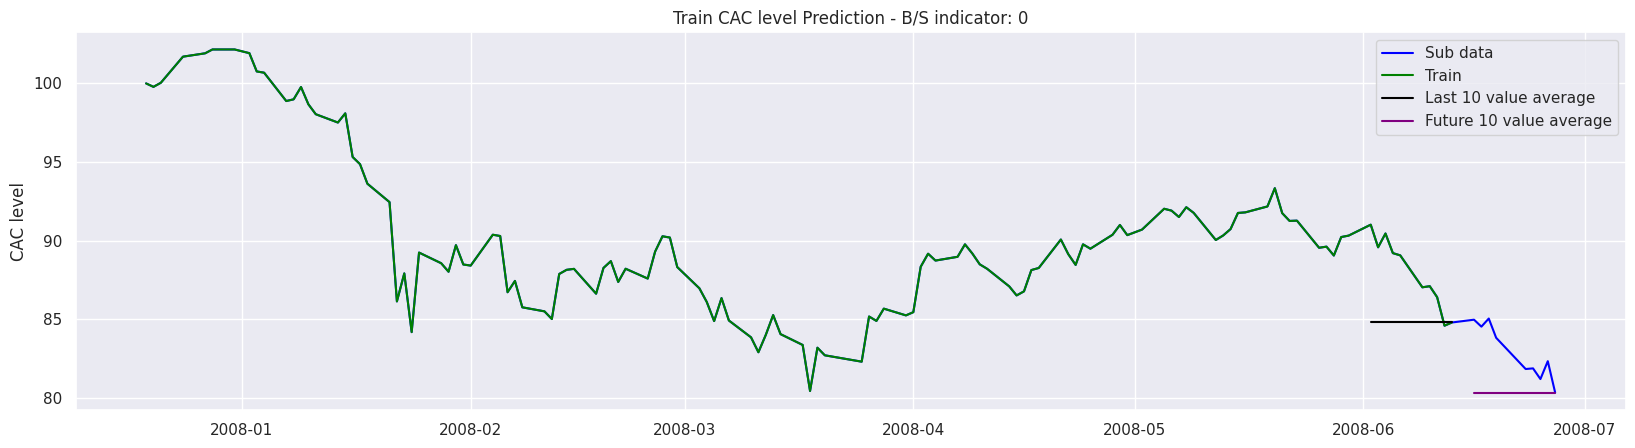

In [ ]:
# subdata OK (Fenetre de selection)
sns.set(rc={'figure.figsize':(20, 7)})

plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
# Visualising the results
#plt.plot(data['opening_price'][BINDEX_AUDIT:EINDEX_AUDIT], color = 'red', label = 'Original data')
plt.plot(data_audit[0]['opening_price'], color = 'blue', label = 'Sub data')

plt.plot(XT_audit[0], color = 'green', label = 'Train')
plt.plot(XT_audit[1], color = 'Black', label = 'Last 10 value average')
plt.plot(XT_audit[2], color = 'purple', label = 'Future 10 value average')


plt.title('Train CAC level Prediction - B/S indicator: {}'.format(yT_audit[0]))

plt.ylabel('CAC level')
plt.legend()
plt.show()

DescribeResult(nobs=4868, minmax=(0, 1), mean=0.562037797863599, variance=0.24620188720879252, skewness=-0.2500836457502568, kurtosis=-1.9374581701282603)

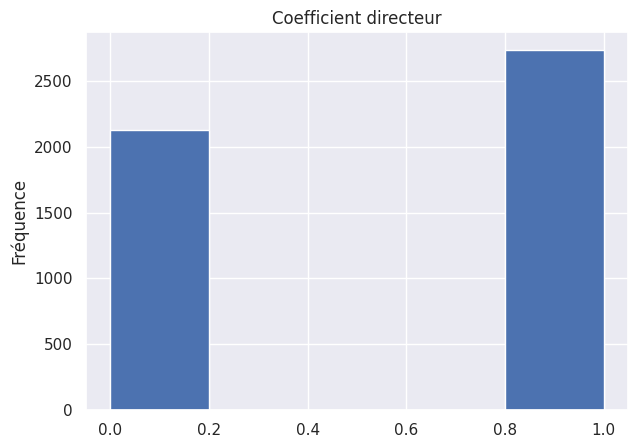

In [ ]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
x = np.array(y_train)
plt.hist(x, bins=5)
plt.gca().set(title='Coefficient directeur', ylabel='Fréquence')

stats.describe(x)

In [ ]:
#On procède de même pour le test set
X_test = []
y_test = []
y = []
mean_diff_test=[]

XTT_audit = []
yTT_audit = []
subdata_auditT = []
data_auditT = []

RAND = randrange(PAST_WINDOW, len(test_set) - FUTURE_WINDOW)


for i in tqdm.tqdm(range(PAST_WINDOW, len(test_set) - FUTURE_WINDOW)):

    subdata = base100(test_set[(i-PAST_WINDOW):(i+FUTURE_WINDOW)], 'Cac index')
    
    a = subdata.opening_price[:-FUTURE_WINDOW]
    b = subdata.RSI[:-FUTURE_WINDOW]
    c = subdata['Cac index'].values[:-FUTURE_WINDOW]

    l = np.column_stack((a, b, c))
    
    mp = subdata.opening_price[:-FUTURE_WINDOW].tail(FUTURE_WINDOW).mean()
    mf = subdata.opening_price.tail(FUTURE_WINDOW).mean()
    X_test.append( l )

    #print("Mean past: {} vs Mean future: {}".format(mp,mf))


    #v = subdata.opening_price[-1]
    mean_diff_test.append((mf-mp)/mp)
    y_test.append( classification(mf, mp) )
    y.append(test_set['Cac index'].values[(i-PAST_WINDOW):i+1][-1])

     # AUDIT DE CODE

    if i == RAND:
      print("\n\nAudited index: {}".format(RAND - PAST_WINDOW))
      print("Mean past: {} vs Mean future: {}".format(mp,mf))
      print("Begin index: {} vs End index: {}\n".format((i-PAST_WINDOW),(i+FUTURE_WINDOW)))
      
      subdataf = subdata.tail(FUTURE_WINDOW).copy() 
      subdatap = subdata[:-FUTURE_WINDOW].tail(FUTURE_WINDOW).copy()

      subdatap['mp'] =  mp
      subdataf['mf'] =  mf

      XTT_audit.append(a)
      XTT_audit.append(subdatap.mp)
      XTT_audit.append(subdataf.mf)

      yTT_audit.append(classification(mf, mp))
      subdata_auditT.append(subdata)
      data_auditT.append(subdata)

      BINDEX_AUDIT = (i-PAST_WINDOW)
      EINDEX_AUDIT = (i+FUTURE_WINDOW)

100%|██████████| 1932/1932 [00:05<00:00, 332.26it/s]



Audited index: 1920
Mean past: 118.17022163632703 vs Mean future: 115.19088317118249
Begin index: 1920 vs End index: 2052



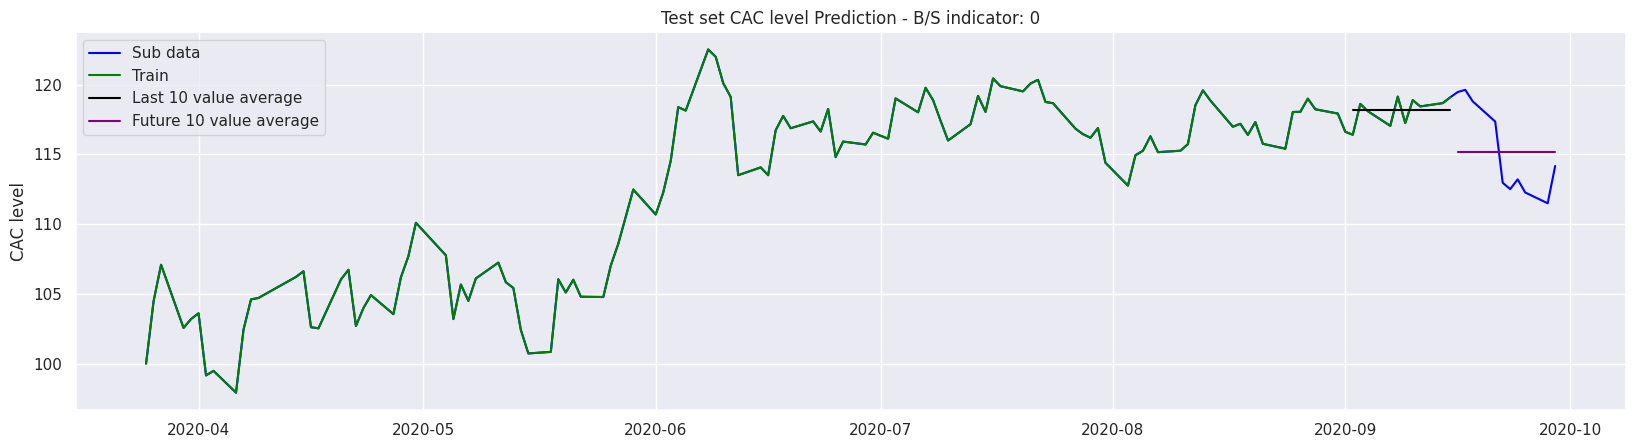

In [ ]:
# subdata OK (Fenetre de selection)
sns.set(rc={'figure.figsize':(20, 7)})

plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
# Visualising the results
#plt.plot(data['opening_price'][BINDEX_AUDIT:EINDEX_AUDIT], color = 'red', label = 'Original data')
plt.plot(data_auditT[0]['opening_price'], color = 'blue', label = 'Sub data')

plt.plot(XTT_audit[0], color = 'green', label = 'Train')
plt.plot(XTT_audit[1], color = 'Black', label = 'Last 10 value average')
plt.plot(XTT_audit[2], color = 'purple', label = 'Future 10 value average')


plt.title('Test set CAC level Prediction - B/S indicator: {}'.format(yTT_audit[0]))

plt.ylabel('CAC level')
plt.legend()
plt.show()

In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 3))

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 3))

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import tensorflow as tf
%matplotlib inline

## Keras for deep learning
from tensorflow.keras import layers
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM,GRU
from keras.layers import Bidirectional, Flatten
from keras.models import Sequential

## Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import plotly.offline as py
import plotly.graph_objs as go

In [ ]:
def LSTM_model(units):
  model = Sequential()
  model.add(LSTM(units=units, input_shape=(X_train.shape[1], 3), return_sequences=True))
  model.add(Dropout(0.5))
  #model.add(BatchNormalization())
  model.add(LSTM(units=units))     
  model.add(Dropout(0.5))
  #model.add(BatchNormalization())
  model.add(Dense(units=units, activation='tanh'))
  model.add(Dropout(0.5))
  #model.add(BatchNormalization())
  model.add(Dense(units=2, activation='softmax'))
  #model.compile(optimizer = 'adam', loss = "mean_squared_error")
  model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

model=LSTM_model(100)

# Fitting
history = model.fit(X_train, y_train, epochs=10, batch_size=200,validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
25/25 [==============================] - 4s 57ms/step - loss: 0.7557 - accuracy: 0.5174 - val_loss: 0.6724 - val_accuracy: 0.5751
Epoch 2/10
25/25 [==============================] - 1s 25ms/step - loss: 0.6959 - accuracy: 0.5369 - val_loss: 0.6714 - val_accuracy: 0.6046
Epoch 3/10
25/25 [==============================] - 1s 25ms/step - loss: 0.6948 - accuracy: 0.5319 - val_loss: 0.6662 - val_accuracy: 0.5797
Epoch 4/10
25/25 [==============================] - 1s 25ms/step - loss: 0.6919 - accuracy: 0.5338 - val_loss: 0.6594 - val_accuracy: 0.5989
Epoch 5/10
25/25 [==============================] - 1s 25ms/step - loss: 0.6863 - accuracy: 0.5591 - val_loss: 0.6656 - val_accuracy: 0.5854
Epoch 6/10
25/25 [==============================] - 1s 25ms/step - loss: 0.6856 - accuracy: 0.5649 - val_loss: 0.6608 - val_accuracy: 0.6434
Epoch 7/10
25/25 [==============================] - 1s 25ms/step - loss: 0.6875 - accuracy: 0.5543 - val_loss: 0.6584 - val_accuracy: 0.6123
Epoch 8/10
25

In [ ]:
# Create a model prone to add layers sequentially
#model = Sequential()
# flatten the data replaces 24*24 matrices by a 576 dimensional vector
# This is always necessary before a fully-connected layer (Dense object)
#model.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2]), name='flatten'))
# add one dense (fully connected layer) with softmax activation function
# As it is the first layer, the input size is mandatory
#model.add(Dense(2, activation='softmax', name='dense_softmax'))

# "compile" this model, 
#model.compile(
    # specify the loss as the cross-entropy i.e. the negative loglikelihood.
    #loss='sparse_categorical_crossentropy',
    # choose the gradient based method to estimate the parameters
    # see https://keras.io/optimizers/ to have an overview of the different options
    # see also section 2 on gradient based methods.
    #optimizer="adam",
    # metric to monitor on the test data
   # metrics=['accuracy']
#)
#model.summary()

In [ ]:
#batch_size = 32
# number of times data are scanned
#epochs = 20
# train the model, i.e. estimate unknown parameters by minimizing the loss function using a gradient descent algorithm (here Adagrad).
#history = model.fit(X_train, y_train,
                    #batch_size=batch_size,
                   # epochs=epochs,
                   # verbose=1,
                    #validation_data=(X_test, y_test))
#score = model.evaluate(X_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

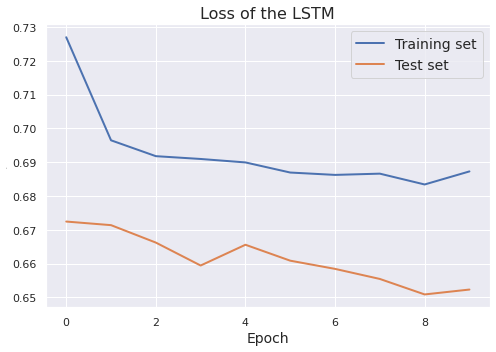

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['loss'], lw=2, label='Training set')
plt.plot(history.epoch, history.history['val_loss'], lw=2, label='Test set')
plt.legend(fontsize=14)
plt.title('Loss of the LSTM', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=1)
plt.tight_layout()

In [ ]:
predicted_coefDir = model.predict(X_test)

In [ ]:
predicted_coefDir

array([[0.43029737, 0.5697026 ],
       [0.42782697, 0.572173  ],
       [0.42989802, 0.570102  ],
       ...,
       [0.48079106, 0.51920897],
       [0.482382  , 0.51761806],
       [0.4865631 , 0.5134369 ]], dtype=float32)

In [ ]:
unique_origin, counts_origin = np.unique(y_test, return_counts=True)
data_dict = dict(zip(unique_origin, counts_origin))

from sklearn.metrics import confusion_matrix
print('Origin labels: ', dict(zip(unique_origin, counts_origin)))

LSTM_y_hat = model.predict(X_test)
LSTM_y_hat_pos = np.argmax(LSTM_y_hat, axis=1)

unique_predict, counts_predict = np.unique(LSTM_y_hat_pos, return_counts=True)
print('Predicted labels: ', dict(zip(unique_predict, counts_predict)))
confusion_m = confusion_matrix(y_test, LSTM_y_hat_pos)
print('Confusion matrix of predicted data:')
print(confusion_m)
a=1
for i in range(len(unique_predict)):
    print('Label {0} accuracy: {1:0.1f}%'.format(i, 100*confusion_m[i,i]/counts_origin[i]))
    a*=np.sqrt(confusion_m[i,i]/counts_origin[i])
    print(a)

Origin labels:  {0: 821, 1: 1111}
Predicted labels:  {0: 248, 1: 1684}
Confusion matrix of predicted data:
[[ 213  608]
 [  35 1076]]
Label 0 accuracy: 25.9%
0.5093522432203169
Label 1 accuracy: 96.8%
0.5012649394931193


In [ ]:
#from sklearn.model_selection import GridSearchCV
#from keras.wrappers.scikit_learn import KerasClassifier

#model = KerasClassifier(build_fn=LSTM_model, verbose=0)

# define the grid search parameters
#epochs=[10]
#param_grid = dict(epochs=epochs)
#grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
#grid_result = grid.fit(X_train, y_train, epochs=10, batch_size=200,validation_data=(X_test, y_test))
# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:

# df = pd.DataFrame({'CACr': y, 'LSTM':LSTM_y_hat_pos, 'Optimal': y_test})
# df['CACr'] = (df.CAC - df.CAC.shift(1))/df.CAC.shift(1)
# df['LSTMr'] = ((df.CAC - df.CAC.shift(1))/df.CAC.shift(1)) * df.LSTM
# df['Optimalr'] = ((df.CAC - df.CAC.shift(1))/df.CAC.shift(1)) * df.Optimal

df = pd.DataFrame({'CACr': np.array(y)/100, 'LSTM':LSTM_y_hat_pos, 'Optimal': y_test})
df['LSTMr'] = df.CACr * df.LSTM
df['Optimalr'] = df.CACr * df.Optimal


def tradingBot(dataframe, assetName, botName, optimalName):
  base = 100.0
  dataframe['opening_price'] = base * (1 + dataframe[assetName].shift(1).fillna(0)).cumprod()
  dataframe['closing_price'] = base * (1 + dataframe[assetName]).cumprod()

  dataframe['opening_price_bot'] = base * (1 + dataframe[botName].shift(1).fillna(0)).cumprod()
  dataframe['closing_price_bot'] = base * (1 + dataframe[botName]).cumprod()

  dataframe['opening_price_opt'] = base * (1 + dataframe[optimalName].shift(1).fillna(0)).cumprod()
  dataframe['closing_price_opt'] = base * (1 + dataframe[optimalName]).cumprod()

  return dataframe



In [ ]:
WINDOW_SIZE = 1200
END_WINDOW = randrange(WINDOW_SIZE, len(y_test))
#END_WINDOW = len(y_test)-150
BEGIN_WINDOW = END_WINDOW - WINDOW_SIZE

subdf = df.iloc[BEGIN_WINDOW:END_WINDOW].copy()
dfTrad = tradingBot(subdf, 'CACr', 'LSTMr', 'Optimalr')

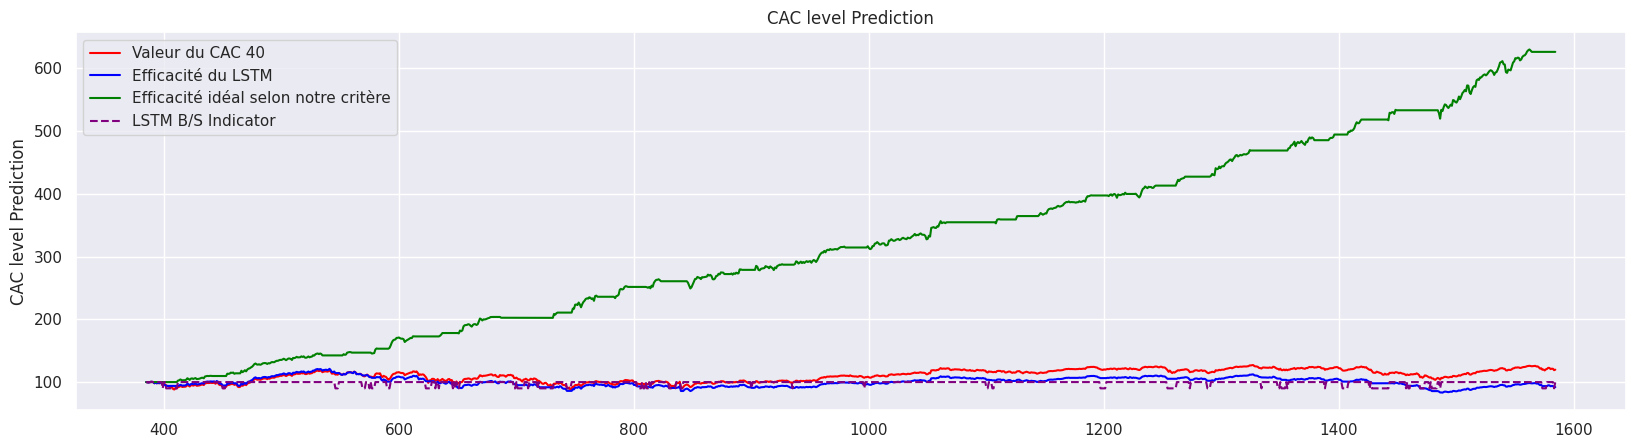

In [ ]:
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
# Visualising the results
plt.plot(dfTrad['opening_price'], color = 'red', label = 'Valeur du CAC 40')
#plt.plot(y[0:200], color = 'red', label = 'Real')

plt.plot(dfTrad['opening_price_bot'], color = 'blue', label = 'Efficacité du LSTM')

plt.plot(dfTrad['opening_price_opt'], color = 'green', label = 'Efficacité idéal selon notre critère')

plt.plot((dfTrad.LSTM * 10) + 90,'r--', color = 'purple', label = 'LSTM B/S Indicator' )

plt.title('CAC level Prediction')

plt.ylabel('CAC level Prediction')
plt.legend()
plt.show()

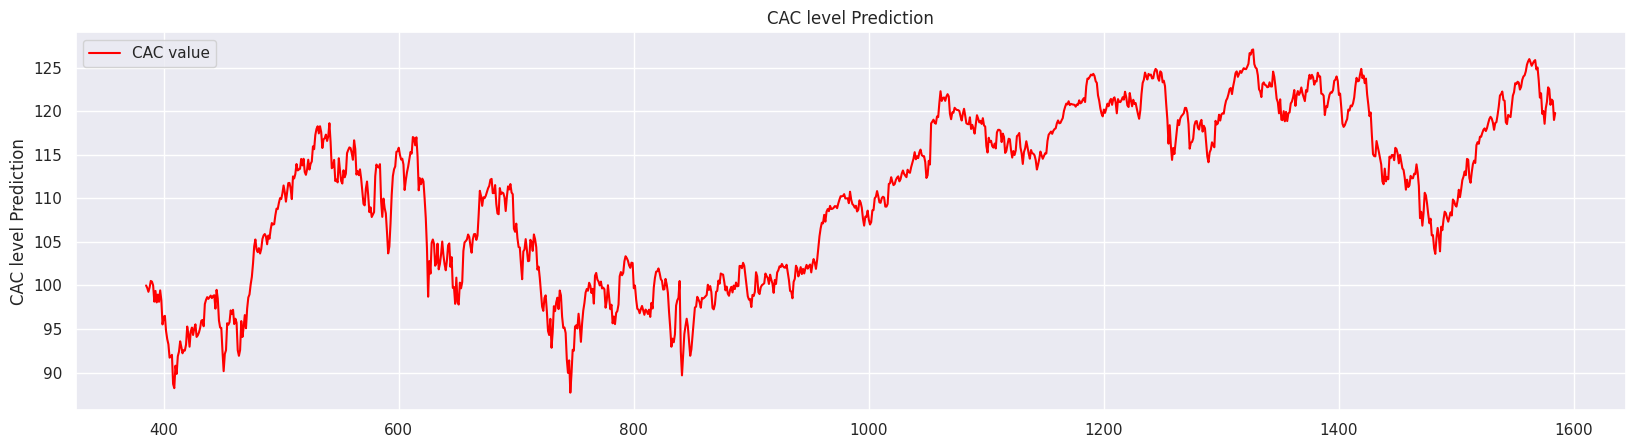

In [ ]:
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
# Visualising the results
plt.plot(dfTrad['opening_price'], color = 'red', label = 'CAC value')
#plt.plot(y[0:200], color = 'red', label = 'Real')

plt.title('CAC level Prediction')

plt.ylabel('CAC level Prediction')
plt.legend()
plt.show()

#**Simulation Monte Carlo**


In [ ]:
def monte_carlo(N_simu):
  simu_mc=np.random.randn(N_simu,1)
  return simu_mc

In [ ]:
WINDOW_SIZE = 150
perfect_perf=[]
trading_bot_perf=[]
cac_perf=[]
perf=[]
perf_area=[]
variances=[]
for i in range(WINDOW_SIZE, len(y_test)):
  END_WINDOW = i
  BEGIN_WINDOW = END_WINDOW - WINDOW_SIZE
  subdf = df.iloc[BEGIN_WINDOW:END_WINDOW].copy()
  dfTrad = tradingBot(subdf, 'CACr', 'LSTMr', 'Optimalr')
  perfect_perf.append(dfTrad['opening_price_opt'].iloc[-1]/100-1) #Efficacité de l'estimateur (courbe verte)
  trading_bot_perf.append(dfTrad['opening_price_bot'].iloc[-1]/100-1) #Efficacité du bot (courbe bleu)
  cac_perf.append(dfTrad['opening_price'].iloc[-1]/100-1) #Evolution du CAC 40 (courbe rouge)
  perf.append((dfTrad['opening_price_bot'].iloc[-1]-dfTrad['opening_price'].iloc[-1])/dfTrad['opening_price'].iloc[-1]) #Efficacité du trading bot par rapport à l'évolution du Cac
  perf_area.append((dfTrad['opening_price_bot']-dfTrad['opening_price']).sum()/dfTrad['opening_price'].sum())
  variances.append(statistics.variance(dfTrad['opening_price'])) 

mean_perfect=statistics.mean(perfect_perf)
mean_bot=statistics.mean(trading_bot_perf)
mean_cac=statistics.mean(cac_perf)
mean_perf=statistics.mean(perf)
mean_perf_area=statistics.mean(perf_area)

print('Perfect perf :' + str(mean_perfect))
print('Bot perf :' + str(mean_bot))
print('Cac perf :' + str(mean_cac))
print('Estimation perf :' + str(mean_perf))
print('Estimation perf area :' + str(mean_perf_area))

Perfect perf :0.26440369936117225
Bot perf :0.011670163568195674
Cac perf :0.021626022439493686
Estimation perf :-0.004740061561126825
Estimation perf area :-0.0038652642899974637


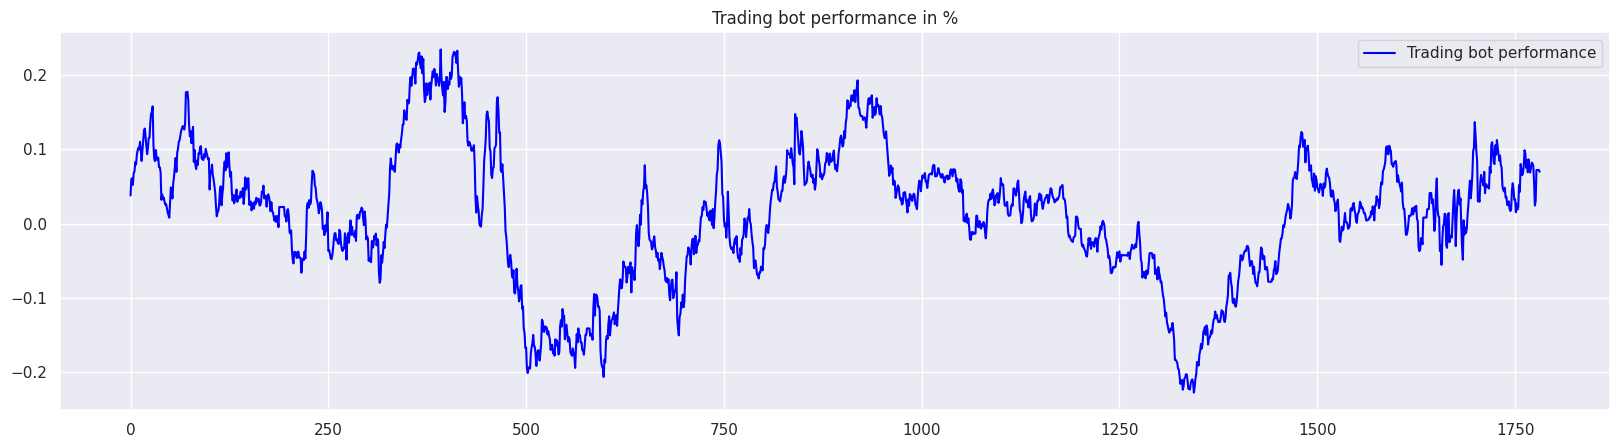

In [ ]:
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
# Visualising the results
plt.plot(trading_bot_perf, color = 'blue', label = 'Trading bot performance')
#plt.plot(y[0:200], color = 'red', label = 'Real')

plt.title('Trading bot performance in %')

plt.legend()
plt.show()

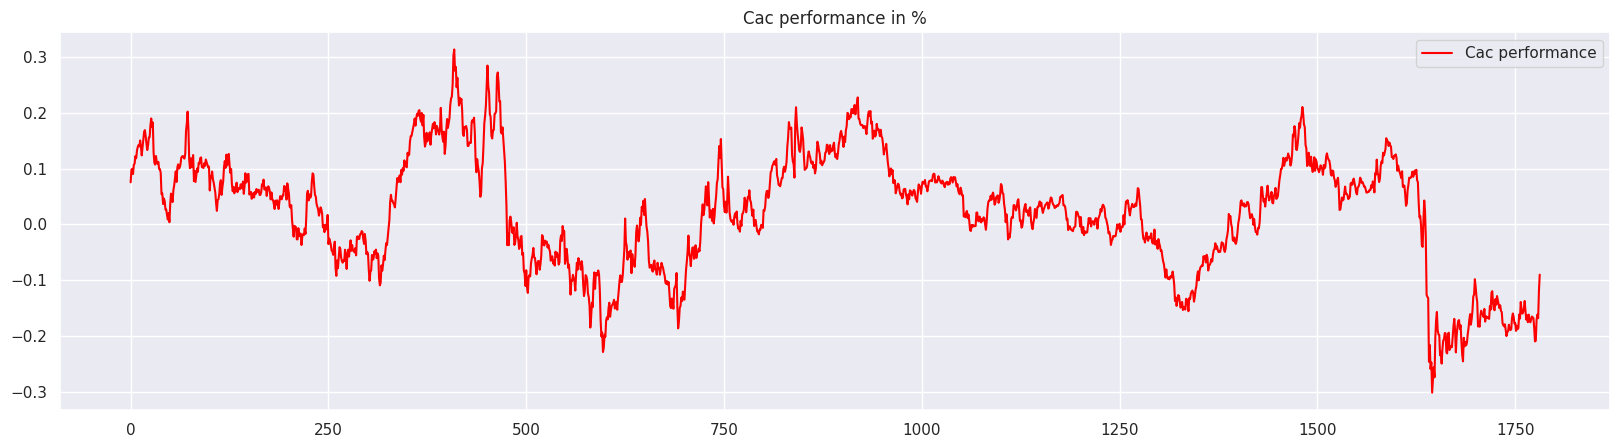

In [ ]:
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
# Visualising the results
plt.plot(cac_perf, color = 'red', label = 'Cac performance')
#plt.plot(y[0:200], color = 'red', label = 'Real')

plt.title('Cac performance in %')

plt.legend()
plt.show()

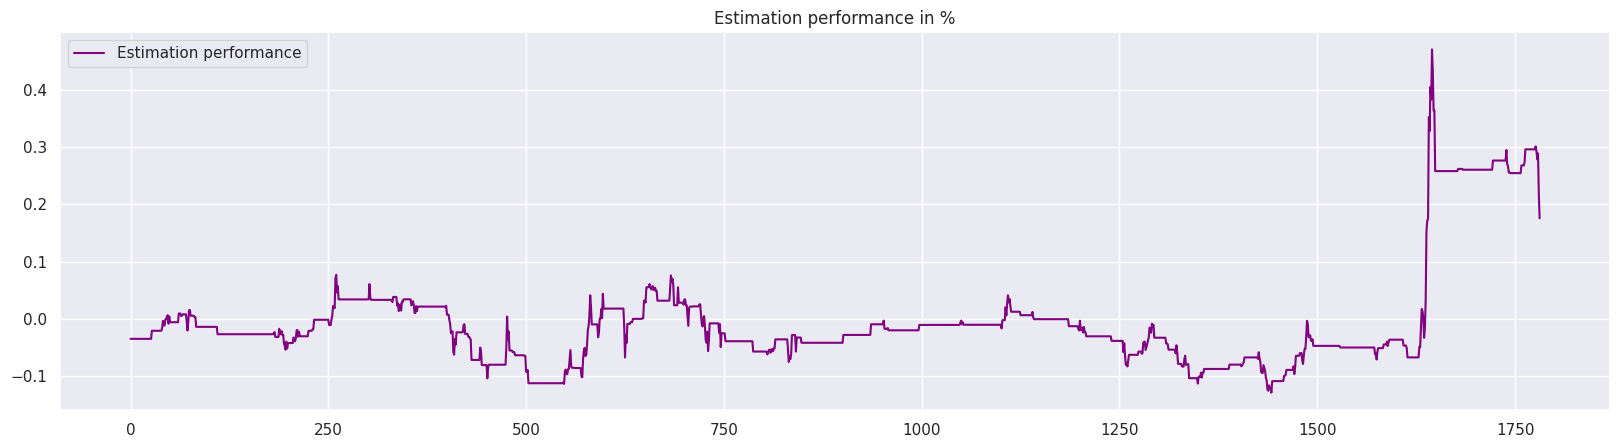

In [ ]:
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
# Visualising the results
plt.plot(perf, color = 'purple', label = 'Estimation performance')
#plt.plot(y[0:200], color = 'red', label = 'Real')

plt.title('Estimation performance in %')

plt.legend()
plt.show()

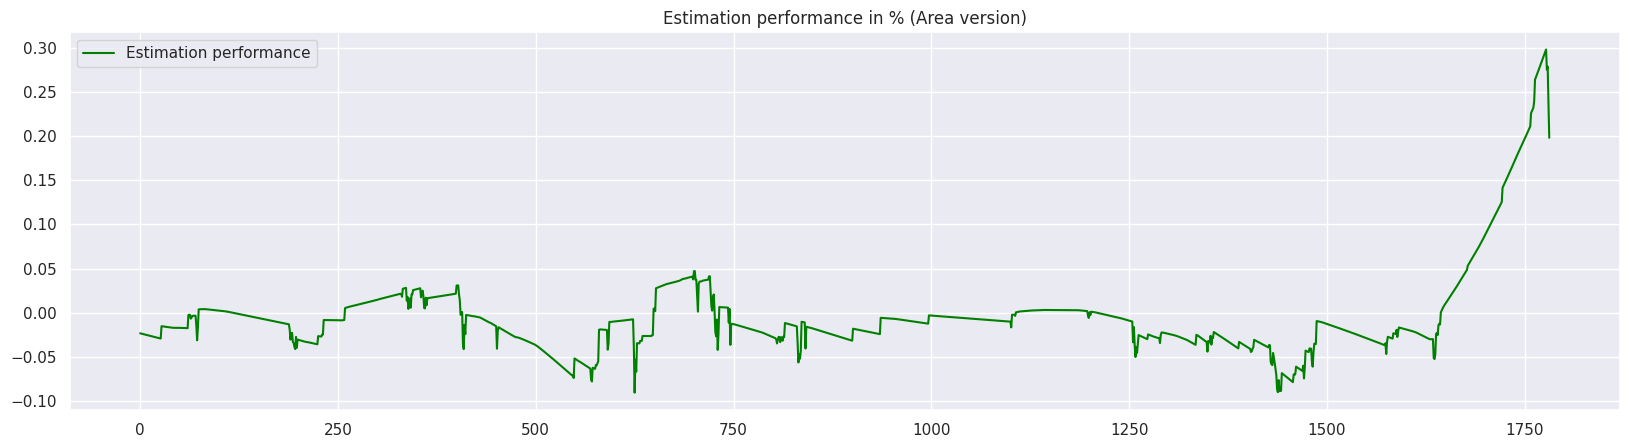

In [ ]:
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
# Visualising the results
plt.plot(perf_area, color = 'green', label = 'Estimation performance')
#plt.plot(y[0:200], color = 'red', label = 'Real')

plt.title('Estimation performance in % (Area version)')

plt.legend()
plt.show()

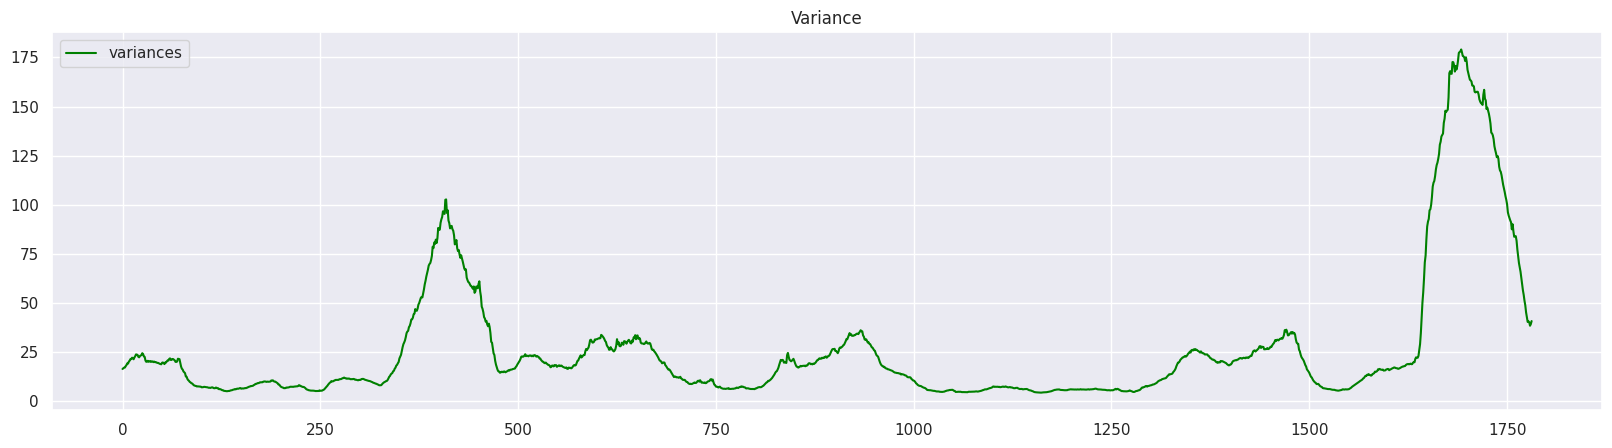

In [ ]:
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
# Visualising the results
plt.plot(variances, color = 'green', label = 'variances')

plt.title('Variance')

plt.legend()
plt.show()

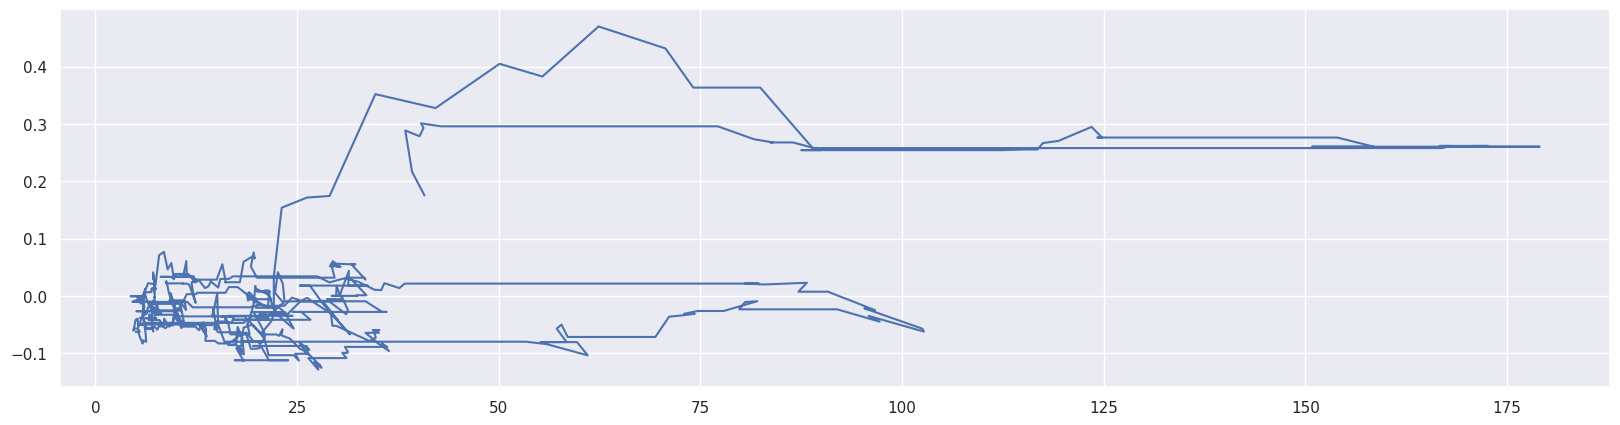

In [ ]:
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})

plt.plot(variances, perf)
plt.show()

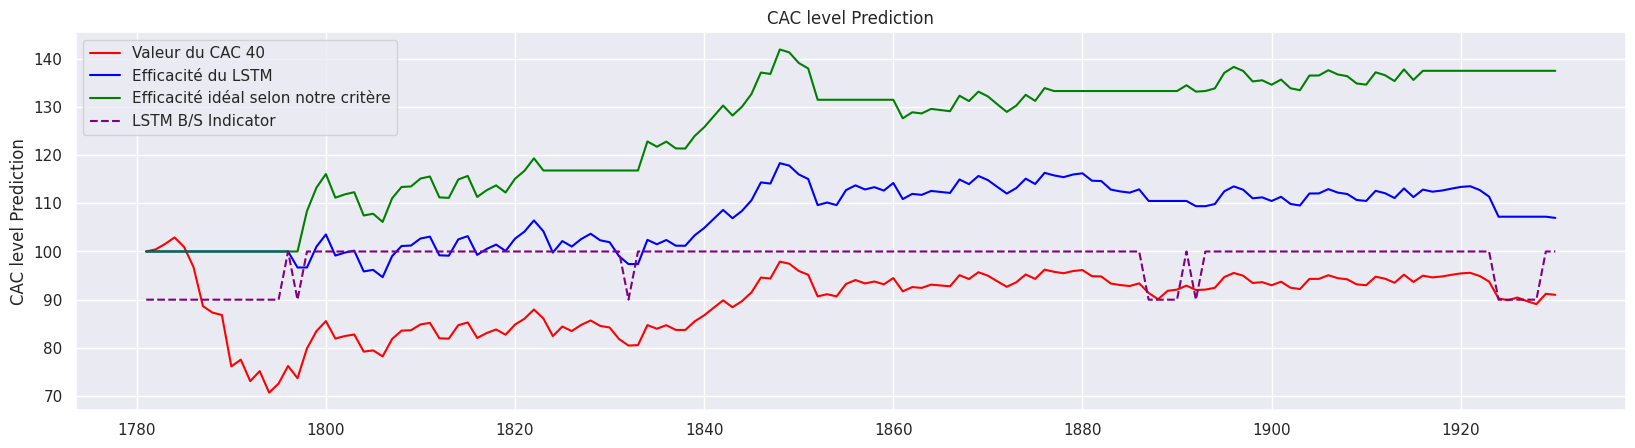

In [ ]:
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
# Visualising the results
plt.plot(dfTrad['opening_price'], color = 'red', label = 'Valeur du CAC 40')
#plt.plot(y[0:200], color = 'red', label = 'Real')

plt.plot(dfTrad['opening_price_bot'], color = 'blue', label = 'Efficacité du LSTM')

plt.plot(dfTrad['opening_price_opt'], color = 'green', label = 'Efficacité idéal selon notre critère')

plt.plot((dfTrad.LSTM * 10) + 90,'r--', color = 'purple', label = 'LSTM B/S Indicator' )

plt.title('CAC level Prediction')

plt.ylabel('CAC level Prediction')
plt.legend()
plt.show()

#**Prediction of sharp drops**

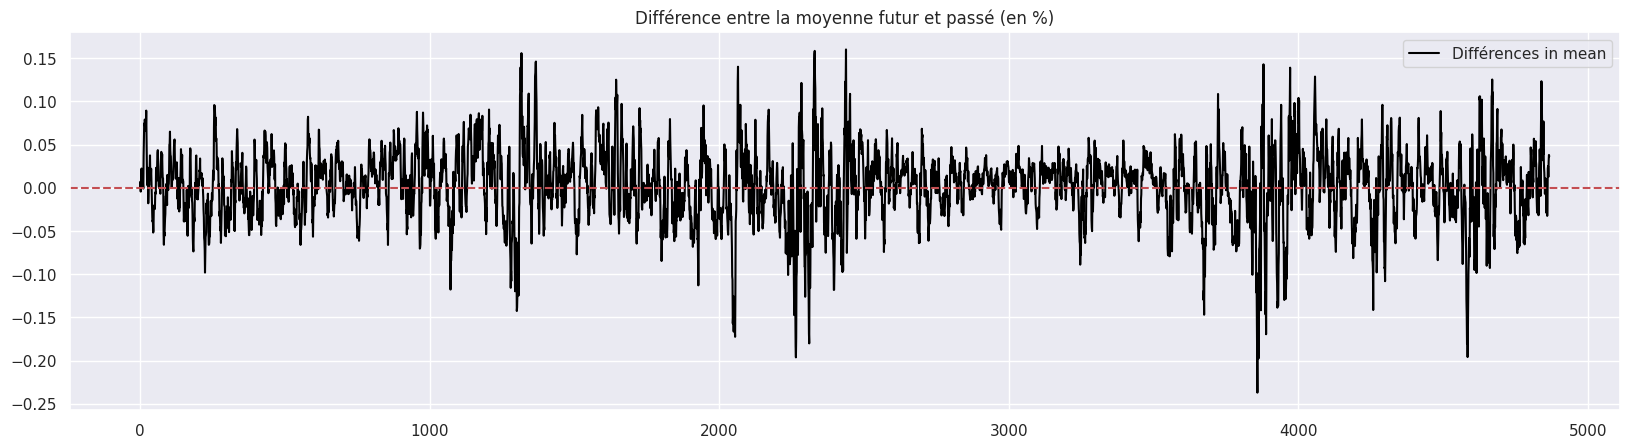

In [ ]:
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
# Visualising the results
plt.plot(mean_diff, color = 'black', label = 'Différences in mean')
plt.axhline(0, color='r', linestyle='--')

plt.title('Différence entre la moyenne futur et passé (en %)')

plt.legend()
plt.show()

In [ ]:
prop=(np.array(mean_diff) > 0.05)*1

proportion=prop.sum()/len(prop)

proportion

0.0961380443714051

In [ ]:
def classification_sharp(v,b):
  if v >= b*(1-0.05):
    return 1
  else:
    return 0

# Creating a data structure with 60 time-steps and 1 output
PAST_WINDOW = 122
FUTURE_WINDOW = 2
X_train_sharp = []
y_train_sharp = []

X_test_sharp = []
y_test_sharp = []

XT_audit_sharp = []
yT_audit_sharp = []
subdata_audit_sharp = []
data_audit_sharp = []

from random import randrange
RAND = randrange(PAST_WINDOW, len(training_set) - FUTURE_WINDOW) #On choisi un nombre aléatoire entre PAST_WINDOW et la taille du train set - FUTURE_WINDOW (C'est la partie du tableau de données sur laquelle on peut classifier les semaines qui suivent)

for i in tqdm.tqdm(range(PAST_WINDOW, len(training_set) - FUTURE_WINDOW)):
    subdata = base100(training_set[(i-PAST_WINDOW):(i+FUTURE_WINDOW)], 'Cac index')
    
    a = subdata.opening_price[:-FUTURE_WINDOW]
    b = subdata.RSI[:-FUTURE_WINDOW]
    c = subdata['Cac index'].values[:-FUTURE_WINDOW]

    l = np.column_stack((a, b, c))
    
    #mp = subdata.opening_price[:-FUTURE_WINDOW].tail(FUTURE_WINDOW).mean() #Moyenne des opening prices sur les future_window derniers jours de l'année
    #mf = subdata.opening_price.tail(FUTURE_WINDOW).mean() #Moyenne des opening prices sur les future_window jours qui suivent l'année
    
    mp = subdata.opening_price[:-FUTURE_WINDOW].tail(1).mean() #Moyenne des opening prices sur les future_window derniers jours de l'année
    mf = subdata.opening_price.tail(1).mean() #Moyenne des opening prices sur les future_window jours qui suivent l'année
    

    X_train_sharp.append( l )
    y_train_sharp.append( classification_sharp(mf, mp) )


    # AUDIT DE CODE
    if i == RAND:
      print("\n\nAudited index: {}".format(RAND - PAST_WINDOW))
      print("Mean past: {} vs Mean future: {}".format(mp,mf))
      print("Begin index: {} vs End index: {}\n".format((i-PAST_WINDOW),(i+FUTURE_WINDOW)))
      
      subdataf = subdata.tail(FUTURE_WINDOW).copy() #future_window derniers jours de l'année
      subdatap = subdata[:-FUTURE_WINDOW].tail(FUTURE_WINDOW).copy() #future_window jours qui suivent l'année

      subdatap['mp'] =  mp
      subdataf['mf'] =  mf

      XT_audit_sharp.append(a)
      XT_audit_sharp.append(subdatap.mp)
      XT_audit_sharp.append(subdataf.mf)

      yT_audit_sharp.append(classification(mf, mp))
      subdata_audit_sharp.append(subdata)
      data_audit_sharp.append(subdata)

      BINDEX_AUDIT = (i-PAST_WINDOW)
      EINDEX_AUDIT = (i+FUTURE_WINDOW)

SyntaxError: ignored

In [ ]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
x_sharp = np.array(y_train_sharp)
plt.hist(x_sharp, bins=5)
plt.gca().set(title='Coefficient directeur', ylabel='Fréquence')

stats.describe(x_sharp)

In [ ]:
#On procède de même pour le test set
X_test_sharp = []
y_test_sharp = []
y_sharp = []
mean_diff_test=[]

XTT_audit_sharp = []
yTT_audit_sharp = []
subdata_auditT_sharp = []
data_auditT_sharp = []

RAND = randrange(PAST_WINDOW, len(test_set) - FUTURE_WINDOW)


for i in tqdm.tqdm(range(PAST_WINDOW, len(test_set) - FUTURE_WINDOW)):

    subdata = base100(test_set[(i-PAST_WINDOW):(i+FUTURE_WINDOW)], 'Cac index')
    
    a = subdata.opening_price[:-FUTURE_WINDOW]
    b = subdata.RSI[:-FUTURE_WINDOW]
    c = subdata['Cac index'].values[:-FUTURE_WINDOW]

    l = np.column_stack((a, b, c))
    
    mp = subdata.opening_price[:-FUTURE_WINDOW].tail(FUTURE_WINDOW).mean()
    mf = subdata.opening_price.tail(FUTURE_WINDOW).mean()
    X_test_sharp.append( l )

    #print("Mean past: {} vs Mean future: {}".format(mp,mf))


    #v = subdata.opening_price[-1]
    mean_diff_test.append((mf-mp)/mp)
    y_test_sharp.append( classification_sharp(mf, mp) )
    y_sharp.append(test_set['Cac index'].values[(i-PAST_WINDOW):i+1][-1])

     # AUDIT DE CODE

    if i == RAND:
      print("\n\nAudited index: {}".format(RAND - PAST_WINDOW))
      print("Mean past: {} vs Mean future: {}".format(mp,mf))
      print("Begin index: {} vs End index: {}\n".format((i-PAST_WINDOW),(i+FUTURE_WINDOW)))
      
      subdataf = subdata.tail(FUTURE_WINDOW).copy() 
      subdatap = subdata[:-FUTURE_WINDOW].tail(FUTURE_WINDOW).copy()

      subdatap['mp'] =  mp
      subdataf['mf'] =  mf

      XTT_audit_sharp.append(a)
      XTT_audit_sharp.append(subdatap.mp)
      XTT_audit_sharp.append(subdataf.mf)

      yTT_audit_sharp.append(classification_sharp(mf, mp))
      subdata_auditT_sharp.append(subdata)
      data_auditT_sharp.append(subdata)

      BINDEX_AUDIT = (i-PAST_WINDOW)
      EINDEX_AUDIT = (i+FUTURE_WINDOW)

In [ ]:
X_train_sharp, y_train_sharp = np.array(X_train_sharp), np.array(y_train_sharp)
X_train_sharp = np.reshape(X_train_sharp, (X_train_sharp.shape[0], X_train_sharp.shape[1], 3))

X_test_sharp, y_test_sharp = np.array(X_test_sharp), np.array(y_test_sharp)
X_test_sharp = np.reshape(X_test_sharp, (X_test_sharp.shape[0], X_test_sharp.shape[1], 3))

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
X_shape_sharp=X_train_sharp.shape
y_shape_sharp=y_train_sharp.shape

X_train_sharp=X_train_sharp.reshape(len(X_train_sharp),-1)


X_train_sharp, y_train_sharp = BorderlineSMOTE(kind='borderline-2').fit_resample(X_train_sharp, y_train_sharp)
#Check the shape of data
print('LSTM_X_data_resample.shape: ', X_train_sharp.shape)
print('LSTM_Y_data_resample.shape: ', y_train_sharp.shape)

unique_origin_resample, counts_origin_resample = np.unique(y_train_sharp, return_counts=True)
data_dict_resample = dict(zip(unique_origin_resample, counts_origin_resample))
print('Origin labels: ', data_dict_resample)

In [ ]:
X_train_sharp= X_train_sharp.reshape(-1,X_shape_sharp[1],X_shape_sharp[2])
X_train_sharp

In [ ]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
x_sharp = np.array(y_train_sharp)
plt.hist(x_sharp, bins=5)
plt.gca().set(title='Coefficient directeur', ylabel='Fréquence')

stats.describe(x_sharp)

In [ ]:
def LSTM_model(units):
  model = Sequential()
  model.add(LSTM(units=units, input_shape=(X_train.shape[1], 3), return_sequences=True))
  model.add(Dropout(0.5))
  #model.add(BatchNormalization())
  model.add(LSTM(units=units))     
  model.add(Dropout(0.5))
  #model.add(BatchNormalization())
  model.add(Dense(units=units, activation='tanh'))
  model.add(Dropout(0.5))
  #model.add(BatchNormalization())
  model.add(Dense(units=2, activation='softmax'))
  #model.compile(optimizer = 'adam', loss = "mean_squared_error")
  model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

model=LSTM_model(100)

# Fitting
history = model.fit(X_train_sharp, y_train_sharp, epochs=10, batch_size=200,validation_data=(X_test_sharp, y_test_sharp))
score = model.evaluate(X_test_sharp, y_test_sharp, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['loss'], lw=2, label='Training set')
plt.plot(history.epoch, history.history['val_loss'], lw=2, label='Test set')
plt.legend(fontsize=14)
plt.title('Loss of the LSTM', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=1)
plt.tight_layout()

In [ ]:
predicted_coefDir = model.predict(X_test_sharp)

In [ ]:
predicted_coefDir

In [ ]:
unique_origin, counts_origin = np.unique(y_test_sharp, return_counts=True)
data_dict = dict(zip(unique_origin, counts_origin))

from sklearn.metrics import confusion_matrix
print('Origin labels: ', dict(zip(unique_origin, counts_origin)))

LSTM_y_hat_sharp = model.predict(X_test_sharp)
LSTM_y_hat_pos_sharp = np.argmax(LSTM_y_hat_sharp, axis=1)

unique_predict_sharp, counts_predict_sharp = np.unique(LSTM_y_hat_pos_sharp, return_counts=True)
print('Predicted labels: ', dict(zip(unique_predict_sharp, counts_predict_sharp)))
confusion_m_sharp = confusion_matrix(y_test_sharp, LSTM_y_hat_pos_sharp)
print('Confusion matrix of predicted data:')
print(confusion_m_sharp)
a=1
for i in range(len(unique_predict_sharp)):
    print('Label {0} accuracy: {1:0.1f}%'.format(i, 100*confusion_m_sharp[i,i]/counts_origin[i]))
    a*=np.sqrt(confusion_m_sharp[i,i]/counts_origin[i])
    print(a)

In [ ]:

# df = pd.DataFrame({'CACr': y, 'LSTM':LSTM_y_hat_pos, 'Optimal': y_test})
# df['CACr'] = (df.CAC - df.CAC.shift(1))/df.CAC.shift(1)
# df['LSTMr'] = ((df.CAC - df.CAC.shift(1))/df.CAC.shift(1)) * df.LSTM
# df['Optimalr'] = ((df.CAC - df.CAC.shift(1))/df.CAC.shift(1)) * df.Optimal


df = pd.DataFrame({'CACr': np.array(y_sharp)/100, 'LSTM':LSTM_y_hat_pos_sharp, 'Optimal': y_test_sharp})
df['LSTMr'] = df.CACr * df.LSTM
df['Optimalr'] = df.CACr * df.Optimal


def tradingBot(dataframe, assetName, botName, optimalName):
  base = 100.0
  dataframe['opening_price'] = base * (1 + dataframe[assetName].shift(1).fillna(0)).cumprod()
  dataframe['closing_price'] = base * (1 + dataframe[assetName]).cumprod()

  dataframe['opening_price_bot'] = base * (1 + dataframe[botName].shift(1).fillna(0)).cumprod()
  dataframe['closing_price_bot'] = base * (1 + dataframe[botName]).cumprod()

  dataframe['opening_price_opt'] = base * (1 + dataframe[optimalName].shift(1).fillna(0)).cumprod()
  dataframe['closing_price_opt'] = base * (1 + dataframe[optimalName]).cumprod()

  return dataframe



In [ ]:
WINDOW_SIZE = 1200
END_WINDOW = randrange(WINDOW_SIZE, len(y_test))
#END_WINDOW = len(y_test)-150
BEGIN_WINDOW = END_WINDOW - WINDOW_SIZE

subdf = df.iloc[BEGIN_WINDOW:END_WINDOW].copy()
dfTrad = tradingBot(subdf, 'CACr', 'LSTMr', 'Optimalr')

In [ ]:
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
# Visualising the results
plt.plot(dfTrad['opening_price'], color = 'red', label = 'Valeur du CAC 40')
#plt.plot(y[0:200], color = 'red', label = 'Real')

plt.plot(dfTrad['opening_price_bot'], color = 'blue', label = 'Efficacité du LSTM')

plt.plot(dfTrad['opening_price_opt'], color = 'green', label = 'Efficacité idéal selon notre critère')

plt.plot((dfTrad.LSTM * 10) + 90,'r--', color = 'purple', label = 'LSTM B/S Indicator' )

plt.title('CAC level Prediction')

plt.ylabel('CAC level Prediction')
plt.legend()
plt.show()

In [ ]:
WINDOW_SIZE = 150
perfect_perf=[]
trading_bot_perf=[]
cac_perf=[]
perf=[]
perf_area=[]
variances=[]
for i in range(WINDOW_SIZE, len(y_test_sharp)):
  END_WINDOW = i
  BEGIN_WINDOW = END_WINDOW - WINDOW_SIZE
  subdf = df.iloc[BEGIN_WINDOW:END_WINDOW].copy()
  dfTrad = tradingBot(subdf, 'CACr', 'LSTMr', 'Optimalr')
  perfect_perf.append(dfTrad['opening_price_opt'].iloc[-1]/100-1) #Efficacité de l'estimateur (courbe verte)
  trading_bot_perf.append(dfTrad['opening_price_bot'].iloc[-1]/100-1) #Efficacité du bot (courbe bleu)
  cac_perf.append(dfTrad['opening_price'].iloc[-1]/100-1) #Evolution du CAC 40 (courbe rouge)
  perf.append((dfTrad['opening_price_bot'].iloc[-1]-dfTrad['opening_price'].iloc[-1])/dfTrad['opening_price'].iloc[-1]) #Efficacité du trading bot par rapport à l'évolution du Cac
  perf_area.append((dfTrad['opening_price_bot']-dfTrad['opening_price']).sum()/dfTrad['opening_price'].sum())
  variances.append(statistics.variance(dfTrad['opening_price'])) 

mean_perfect=statistics.mean(perfect_perf)
mean_bot=statistics.mean(trading_bot_perf)
mean_cac=statistics.mean(cac_perf)
mean_perf=statistics.mean(perf)
mean_perf_area=statistics.mean(perf_area)

print('Perfect perf :' + str(mean_perfect))
print('Bot perf :' + str(mean_bot))
print('Cac perf :' + str(mean_cac))
print('Estimation perf :' + str(mean_perf))
print('Estimation perf area :' + str(mean_perf_area))

In [ ]:
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
# Visualising the results
plt.plot(perf, color = 'purple', label = 'Estimation performance')
plt.axhline(0, color='r', linestyle='--')
#plt.plot(y[0:200], color = 'red', label = 'Real')

plt.title('Estimation performance in %')

plt.legend()
plt.show()

In [ ]:
pour_perf=(np.array(trading_bot_perf)>np.array(cac_perf)).mean()

print('Proprtion surp :' + str(pour_perf))

In [ ]:
new_list=(LSTM_y_hat_pos==LSTM_y_hat_pos_sharp)*1

df = pd.DataFrame({'CACr': np.array(y)/100, 'LSTM':new_list, 'Optimal': y_test})
df['LSTMr'] = df.CACr * df.LSTM
df['Optimalr'] = df.CACr * df.Optimal


def tradingBot(dataframe, assetName, botName, optimalName):
  base = 100.0
  dataframe['opening_price'] = base * (1 + dataframe[assetName].shift(1).fillna(0)).cumprod()
  dataframe['closing_price'] = base * (1 + dataframe[assetName]).cumprod()

  dataframe['opening_price_bot'] = base * (1 + dataframe[botName].shift(1).fillna(0)).cumprod()
  dataframe['closing_price_bot'] = base * (1 + dataframe[botName]).cumprod()

  dataframe['opening_price_opt'] = base * (1 + dataframe[optimalName].shift(1).fillna(0)).cumprod()
  dataframe['closing_price_opt'] = base * (1 + dataframe[optimalName]).cumprod()

  return dataframe



In [ ]:
WINDOW_SIZE = 150
END_WINDOW = randrange(WINDOW_SIZE, len(y_test))
#END_WINDOW = len(y_test)-150
BEGIN_WINDOW = END_WINDOW - WINDOW_SIZE

subdf = df.iloc[BEGIN_WINDOW:END_WINDOW].copy()
dfTrad = tradingBot(subdf, 'CACr', 'LSTMr', 'Optimalr')

In [ ]:
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
# Visualising the results
plt.plot(dfTrad['opening_price'], color = 'red', label = 'Valeur du CAC 40')
#plt.plot(y[0:200], color = 'red', label = 'Real')

plt.plot(dfTrad['opening_price_bot'], color = 'blue', label = 'Efficacité du LSTM')

plt.plot(dfTrad['opening_price_opt'], color = 'green', label = 'Efficacité idéal selon notre critère')

plt.plot((dfTrad.LSTM * 10) + 90,'r--', color = 'purple', label = 'LSTM B/S Indicator' )

plt.title('CAC level Prediction')

plt.ylabel('CAC level Prediction')
plt.legend()
plt.show()